<a href="https://colab.research.google.com/github/smendes801/Draft/blob/main/Space_Debris_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Debris

In [3]:
!pip install sgp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 6.1 MB/s eta 0:00:00



SPACE DEBRIS CLASSIFICATION ANALYSIS


--------------------
1. Data Processing
--------------------
Loading data from sources...
• Total objects processed: 3209
• Features extracted: 11

--------------------
2. Feature Selection
--------------------


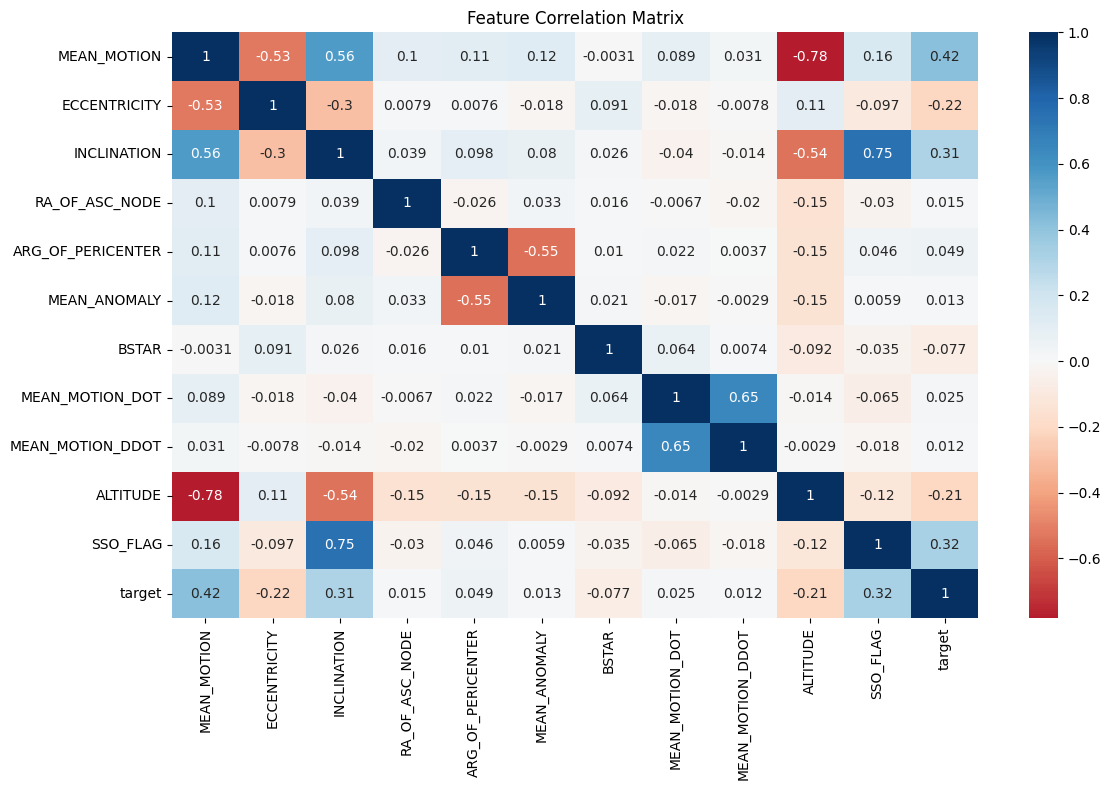


Selected Features:
  1. MEAN_MOTION
  2. SSO_FLAG
  3. INCLINATION
  4. ARG_OF_PERICENTER
  5. MEAN_MOTION_DOT
  6. RA_OF_ASC_NODE
  7. MEAN_ANOMALY

--------------------
3. Model Training
--------------------

--------------------
4. Model Evaluation
--------------------

Model Performance Metrics:
Accuracy: 0.9393
Precision: 0.9393
Recall: 0.9906
F1 Score: 0.9643


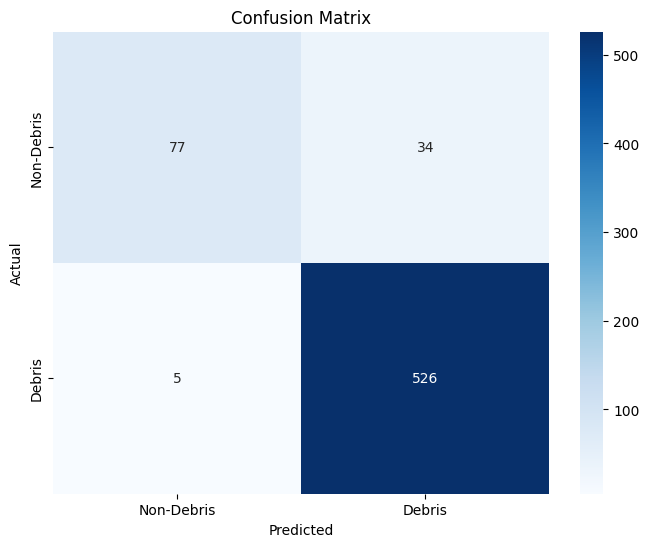

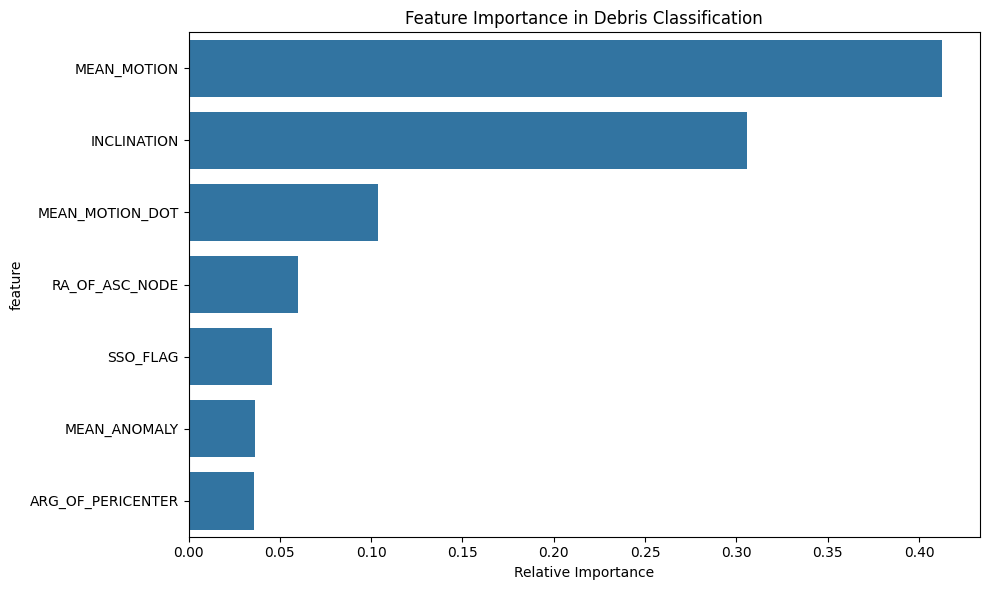


Model Performance:
  • Accuracy:  93.93%
  • Precision: 93.93%
  • Recall:    99.06%
  • F1 Score:  96.43%

--------------------
5. Orbital Analysis
--------------------

Orbital Statistics:

Debris Objects:
  • Count: 2652
  • Altitude Range: 235.1 - 1988.0 km
  • Mean Motion: 14.28 orbits/day
  • SSO Objects: 1866

Non-Debris Objects:
  • Count: 557
  • Altitude Range: 374.7 - 526392.6 km
  • Mean Motion: 12.46 orbits/day
  • SSO Objects: 164

--------------------
6. Visualizations
--------------------
Generating plots...


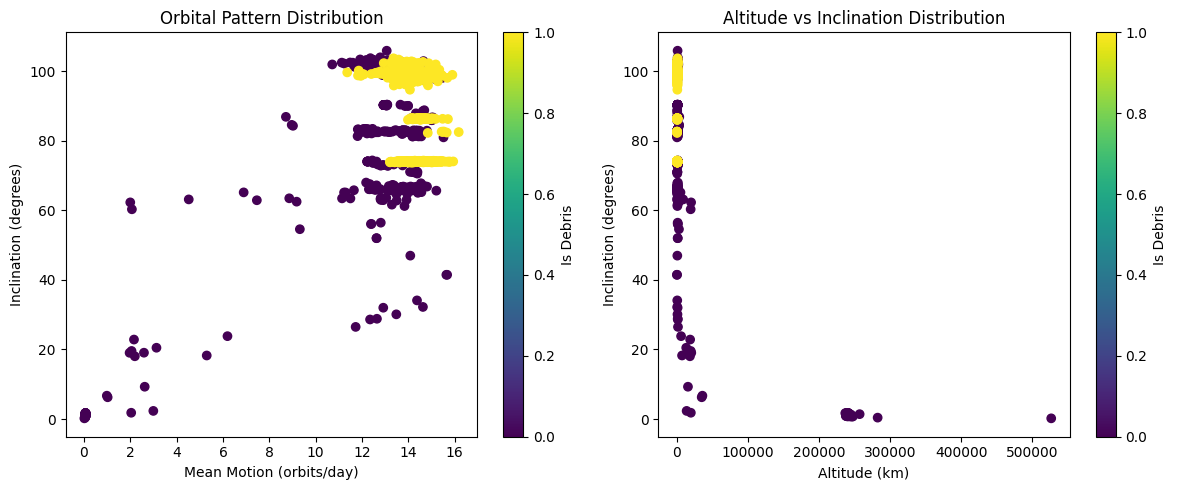


--------------------
7. Model Comparison
--------------------

Model Comparison Results:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score   CV Score  
--------------------------------------------------------------------------------
Logistic Regression  0.9003    0.9118    0.9736    0.9417    0.9003
Random Forest        0.9361    0.9359    0.9906    0.9625    0.9303
SVM                  0.9206    0.9152    0.9962    0.9540    0.9038
Naive Bayes          0.8910    0.9183    0.9529    0.9353    0.9026
KNN                  0.9143    0.9161    0.9868    0.9501    0.9081
Decision Tree        0.9361    0.9520    0.9718    0.9618    0.9201


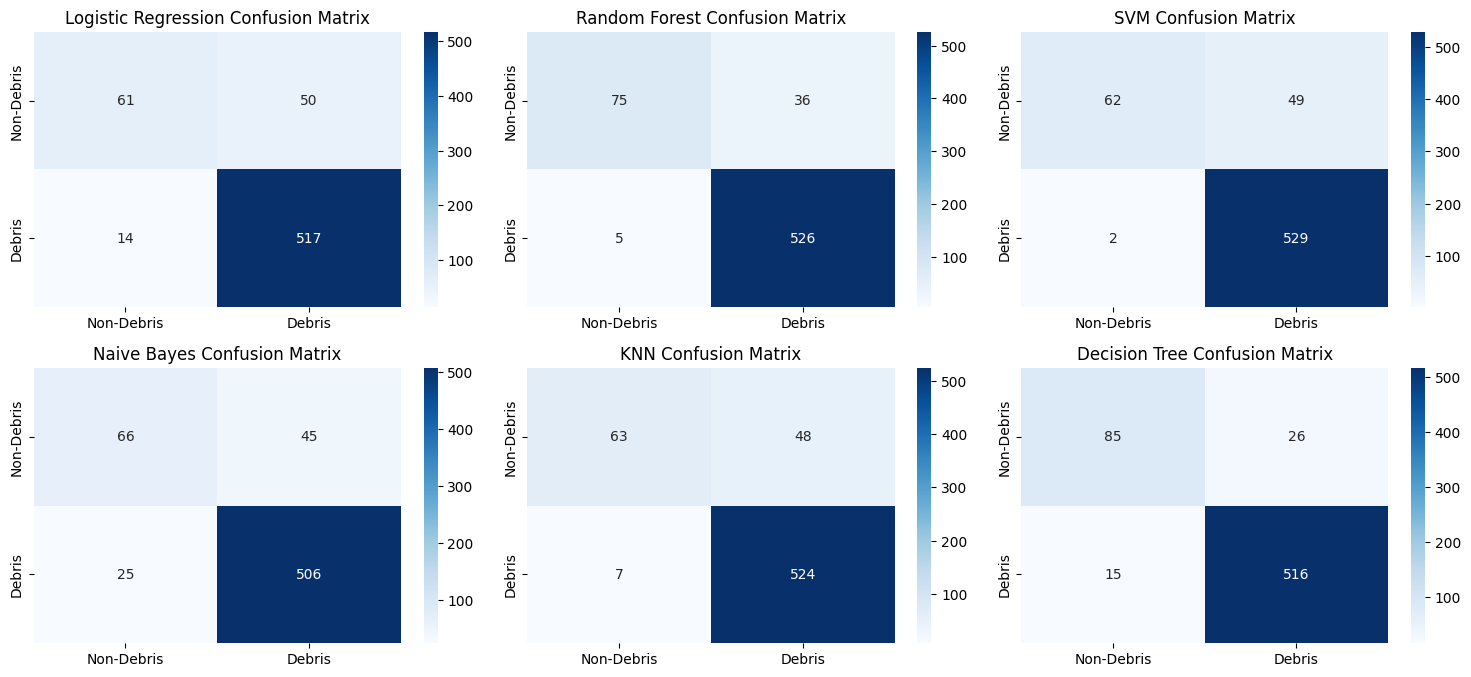

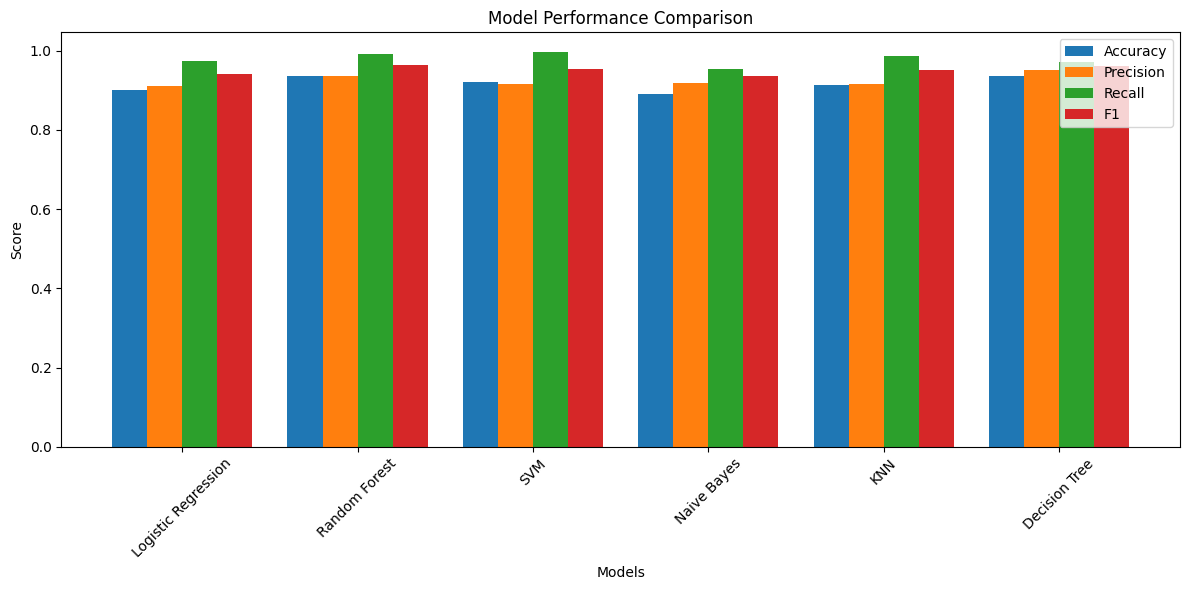


Analysis Complete



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import requests
from sgp4.api import Satrec

# --- 1. Data Acquisition and Preprocessing ---

def mean_motion_to_altitude(mean_motion):
    """Convert mean motion to orbital altitude."""
    mu = 3.986e14  # Earth's gravitational parameter (m³/s²)
    revs_per_sec = mean_motion / 86400
    semi_major_axis = (mu / ((2 * np.pi * revs_per_sec)**2))**(1/3)
    altitude_km = (semi_major_axis / 1000) - 6371  # Earth radius in km
    return altitude_km

def calculate_derived_features(df):
    """Calculate additional derived features."""
    df['ALTITUDE'] = df['MEAN_MOTION'].apply(mean_motion_to_altitude)
    df['SSO_FLAG'] = df['INCLINATION'].apply(lambda x: 1 if 96 < x < 102 else 0)
    return df

def load_data():
    # URLs and their labels
    data_sources = {
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=analyst&FORMAT=csv": "satellite",
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-1408-debris&FORMAT=csv": "debris",
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=fengyun-1c-debris&FORMAT=csv": "debris",
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=iridium-33-debris&FORMAT=csv": "debris",
        "https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-2251-debris&FORMAT=csv": "debris"
    }

    # Load and label each dataset
    all_dfs = []
    for url, label in data_sources.items():
        try:
            df = pd.read_csv(url)
            df['label'] = label
            all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {url}: {e}")

    # Fetch and parse "impending reentry" TLE data
    tle_url = "https://celestrak.org/NORAD/elements/gp-last.php?SPECIAL=IMPENDING&FORMAT=tle"
    tle_text = requests.get(tle_url).text
    tle_lines = tle_text.strip().splitlines()

    impending_data = []
    for i in range(0, len(tle_lines), 3):
        if i + 2 >= len(tle_lines):
            break
        name = tle_lines[i].strip()
        line1 = tle_lines[i + 1].strip()
        line2 = tle_lines[i + 2].strip()
        try:
            sat = Satrec.twoline2rv(line1, line2)
            data_point = {
                'MEAN_MOTION': sat.no_kozai,
                'ECCENTRICITY': sat.ecco,
                'INCLINATION': sat.inclo,
                'RA_OF_ASC_NODE': sat.nodeo,
                'ARG_OF_PERICENTER': sat.argpo,
                'MEAN_ANOMALY': sat.mo,
                'BSTAR': sat.bstar,
                'MEAN_MOTION_DOT': sat.ndot,
                'MEAN_MOTION_DDOT': sat.nddot,
                'label': 'impending_reentry'
            }
            impending_data.append(data_point)
        except Exception as e:
            print(f"Error parsing TLE for {name}: {e}")
            continue

    df_impending = pd.DataFrame(impending_data)

    # Combine all datasets
    combined_df = pd.concat(all_dfs + [df_impending], ignore_index=True)

    # Add derived features
    combined_df = calculate_derived_features(combined_df)

    return combined_df


# --- 2. Feature Engineering and Selection ---

def prepare_features(df):
    # Select relevant orbital features
    features = [
        'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
        'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'BSTAR', 'MEAN_MOTION_DOT',
        'MEAN_MOTION_DDOT', 'ALTITUDE', 'SSO_FLAG'
    ]

    # Create feature matrix X and target vector y
    df_clean = df[features + ['label']].dropna()
    X = df_clean[features]
    y = (df_clean['label'] == 'debris').astype(int)

    return X, y, features

def analyze_feature_importance(X, y, features):
    data = X.copy()
    data['target'] = y
    correlations = data.corr()['target'].sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='RdBu', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    return correlations

def create_feature_subsets(X, correlations, n_features=7):
    top_features = correlations.drop('target').nlargest(n_features).index
    X_selected = X[top_features]
    return X_selected, top_features


# --- 3. Model Training and Evaluation ---

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Debris', 'Debris'],
                yticklabels=['Non-Debris', 'Debris'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Debris Classification')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'feature_importance': feature_importance,
        'model': model
    }


# --- 4. Orbital Pattern and Debris Characteristics Analysis ---

def analyze_orbital_patterns(X, y):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X['MEAN_MOTION'], X['INCLINATION'], c=y)
    plt.xlabel('Mean Motion (orbits/day)')
    plt.ylabel('Inclination (degrees)')
    plt.title('Orbital Pattern Distribution')
    plt.colorbar(label='Is Debris')

    plt.subplot(1, 2, 2)
    plt.scatter(X['ALTITUDE'], X['INCLINATION'], c=y)
    plt.xlabel('Altitude (km)')
    plt.ylabel('Inclination (degrees)')
    plt.title('Altitude vs Inclination Distribution')
    plt.colorbar(label='Is Debris')

    plt.tight_layout()
    plt.show()

def analyze_debris_characteristics(X, y):
    debris_objects = X[y == 1]
    non_debris = X[y == 0]

    print("Debris Orbital Characteristics:")
    print(debris_objects.describe())
    print("\nNon-Debris Orbital Characteristics:")
    print(non_debris.describe())

    print("\nAltitude Analysis:")
    print(f"Debris Altitude Range: {debris_objects['ALTITUDE'].min():.1f} - {debris_objects['ALTITUDE'].max():.1f} km")
    print(f"Non-Debris Altitude Range: {non_debris['ALTITUDE'].min():.1f} - {non_debris['ALTITUDE'].max():.1f} km")
    print(f"\nSSO Objects:")
    print(f"Debris in SSO: {debris_objects['SSO_FLAG'].sum()} objects")
    print(f"Non-Debris in SSO: {non_debris['SSO_FLAG'].sum()} objects")


# --- 5. Model Comparison and Selection ---

def get_models():
    """Return a dictionary of models to compare."""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42),
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)
    }
    return models

def compare_models(X_train, X_test, y_train, y_test):
    """Compare different machine learning models and return their performance metrics."""
    models = get_models()
    results = {}

    print("\nModel Comparison Results:")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'CV Score':<10}")
    print("-" * 80)

    plt.figure(figsize=(15, 10))

    for idx, (name, model) in enumerate(models.items()):
        # Train and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        cv_mean = cv_scores.mean()

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'cv_score': cv_mean
        }

        # Print results
        print(f"{name:<20} {accuracy:.4f}    {precision:.4f}    {recall:.4f}    {f1:.4f}    {cv_mean:.4f}")

        # Plot confusion matrix
        plt.subplot(3, 3, idx + 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non-Debris', 'Debris'],
                   yticklabels=['Non-Debris', 'Debris'])
        plt.title(f'{name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    # Plot comparative bar chart
    plt.figure(figsize=(12, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(models))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in results]
        plt.bar(x + i * width, values, width, label=metric.capitalize())

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * 1.5, list(models.keys()), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

def format_model_comparison(results):
    """Format and print the model comparison results in a detailed way."""
    print("\nDetailed Model Comparison Analysis:")
    print("=" * 80)

    # Find best model for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'cv_score']
    best_models = {}

    for metric in metrics:
        best_model = max(results.items(), key=lambda x: x[1][metric])
        best_models[metric] = (best_model[0], best_model[1][metric])

    # Print best models
    print("\nBest Models by Metric:")
    for metric, (model, score) in best_models.items():
        print(f"• Best {metric.replace('_', ' ').title()}: {model} ({score:.4f})")

    print("\nModel Strengths Analysis:")
    print("-" * 80)
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"• Overall Performance: {metrics['accuracy']:.4f} accuracy")
        print(f"• Precision vs Recall: {metrics['precision']:.4f} vs {metrics['recall']:.4f}")
        print(f"• Cross-validation Score: {metrics['cv_score']:.4f}")


# --- 6. Main Workflow and Execution ---

def print_analysis_header():
    print("\n" + "="*50)
    print("SPACE DEBRIS CLASSIFICATION ANALYSIS")
    print("="*50 + "\n")

def print_section(title):
    print("\n" + "-"*20)
    print(f"{title}")
    print("-"*20)

def format_metrics(metrics):
    print("\nModel Performance:")
    print(f"  • Accuracy:  {metrics['accuracy']:.2%}")
    print(f"  • Precision: {metrics['precision']:.2%}")
    print(f"  • Recall:    {metrics['recall']:.2%}")
    print(f"  • F1 Score:  {metrics['f1']:.2%}")

def format_feature_list(features):
    print("\nSelected Features:")
    for i, feature in enumerate(features, 1):
        print(f"  {i}. {feature}")

def format_orbital_stats(X, y):
    debris = X[y == 1]
    non_debris = X[y == 0]

    print("\nOrbital Statistics:")
    print("\nDebris Objects:")
    print(f"  • Count: {len(debris)}")
    print(f"  • Altitude Range: {debris['ALTITUDE'].min():.1f} - {debris['ALTITUDE'].max():.1f} km")
    print(f"  • Mean Motion: {debris['MEAN_MOTION'].mean():.2f} orbits/day")
    print(f"  • SSO Objects: {debris['SSO_FLAG'].sum()}")

    print("\nNon-Debris Objects:")
    print(f"  • Count: {len(non_debris)}")
    print(f"  • Altitude Range: {non_debris['ALTITUDE'].min():.1f} - {non_debris['ALTITUDE'].max():.1f} km")
    print(f"  • Mean Motion: {non_debris['MEAN_MOTION'].mean():.2f} orbits/day")
    print(f"  • SSO Objects: {non_debris['SSO_FLAG'].sum()}")


def main():
    # Print header
    print_analysis_header()

    # Data Loading
    print_section("1. Data Processing")
    print("Loading data from sources...")
    df = load_data()
    X, y, features = prepare_features(df)
    print(f"• Total objects processed: {len(df)}")
    print(f"• Features extracted: {len(features)}")

    # Feature Analysis
    print_section("2. Feature Selection")
    correlations = analyze_feature_importance(X, y, features)
    X_selected, selected_features = create_feature_subsets(X, correlations)
    format_feature_list(selected_features)

    # Model Training
    print_section("3. Model Training")
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns
    )

    # Model Evaluation
    print_section("4. Model Evaluation")
    metrics = train_and_evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test)
    format_metrics(metrics)

    # Orbital Analysis
    print_section("5. Orbital Analysis")
    format_orbital_stats(X, y)

    # Visualization
    print_section("6. Visualizations")
    print("Generating plots...")
    analyze_orbital_patterns(X, y)


    # Model Comparison
    print_section("7. Model Comparison")
    compare_models(X_train_scaled, X_test_scaled, y_train, y_test)


    print("\n" + "="*50)
    print("Analysis Complete")
    print("="*50 + "\n")

if __name__ == "__main__":
    main()